In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
from keras.callbacks import EarlyStopping
import datetime
%matplotlib inline


#Importing necessary packages and read data
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error


file_name_before = 'Bitcoin_before_trading_clean.csv'
df_before_trading = pd.DataFrame(pd.read_csv(file_name_before))

file_name_after = 'Bitcoin_after_trading_clean.csv'
df_after_trading = pd.DataFrame(pd.read_csv(file_name_after))



In [3]:
FEATURES = ['High', 'Low', 'Open','Close', 'Volume' , 'Marketcap']

multivariative_df_before = pd.DataFrame(df_after_trading)
multivariative_df_before = df_after_trading[FEATURES]
#Create prediction column and set dummy values to prepare the data
multivariative_df_before['Prediction'] = df_after_trading['Close']



<ipython-input-3-e4d60a5759f8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multivariative_df_before['Prediction'] = df_after_trading['Close']


In [4]:
#Number of rows
nrows = multivariative_df_before.shape[0]
np_multivariative_df_before_unscaled = np.array(multivariative_df_before)
np_multivariative_df_before_unscaled = np.reshape(np_multivariative_df_before_unscaled, (nrows, -1))


#Transform data by scaling
multivariative_scaler_before = MinMaxScaler(feature_range=(0,1))
multivariative_scaler_data_before = multivariative_scaler_before.fit_transform(np_multivariative_df_before_unscaled)

#
scaler_pred = MinMaxScaler(feature_range=(0,1))
df_close = pd.DataFrame(df_before_trading['Close'])
close_scaled = scaler_pred.fit_transform(df_close)

In [5]:
#Set up X_train and y_train
sequence_length = 60
train_data_len = math.ceil(multivariative_scaler_data_before.shape[0] * 0.75)
train_data = multivariative_scaler_data_before[0:train_data_len, :]
X_train, y_train = [], []

for i in range(60, train_data_len):
    X_train.append(train_data[i-sequence_length:i, :])
    y_train.append(train_data[i, 0])
    
#Convert X_train and y_train to np array
X_train = np.array(X_train)
y_train = np.array(y_train)



#Create test data
test_data = multivariative_scaler_data_before[train_data_len - sequence_length :, :]

X_test, y_test = [], []
test_data_len = test_data.shape[0]

for i in range(sequence_length, test_data_len):
    X_test.append(test_data[i-sequence_length :i, :])
    y_test.append(test_data[i, 0])

#Convert X_test and y_test to np array
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1905, 60, 7) (1905,)
(655, 60, 7) (655,)


In [6]:
#Set up sequential model
multivariative_model = Sequential()

#model with 600 neurons
n_neurons = X_train.shape[1] * X_train.shape[2]
multivariative_model.add(LSTM(n_neurons, return_sequences=False))
multivariative_model.add(Dense(64))
multivariative_model.add(Dense(1, activation = 'relu'))

#Compile 
multivariative_model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

In [7]:
epochs_size = 10
#early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
multi_history = multivariative_model.fit(X_train, y_train, batch_size=200, epochs=epochs_size,
                                         validation_split=0.3)

Epoch 1/10
7/7 [==============================] - 4s 404ms/step - loss: 6.6666e-04 - accuracy: 4.1671e-04 - val_loss: 7.1369e-04 - val_accuracy: 0.0000e+00
Epoch 2/10
7/7 [==============================] - 2s 333ms/step - loss: 1.2699e-04 - accuracy: 7.8130e-04 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 3/10
7/7 [==============================] - 2s 338ms/step - loss: 8.0581e-05 - accuracy: 0.0011 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 4/10
7/7 [==============================] - 2s 338ms/step - loss: 3.8040e-05 - accuracy: 2.9171e-04 - val_loss: 7.0471e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
7/7 [==============================] - 2s 341ms/step - loss: 6.4710e-06 - accuracy: 5.7296e-04 - val_loss: 4.9163e-04 - val_accuracy: 0.0000e+00
Epoch 6/10
7/7 [==============================] - 2s 344ms/step - loss: 1.0074e-05 - accuracy: 7.8130e-04 - val_loss: 1.0748e-04 - val_accuracy: 0.0000e+00
Epoch 7/10
7/7 [==============================] - 2s 347ms/step - loss: 1.98

In [8]:

#Prediction
multi_prediction = multivariative_model.predict(X_test)

#RMSE
multi_RMSE = np.sqrt(mean_squared_error(multi_prediction, y_test))

#MAE
multi_MAE = mean_absolute_error(multi_prediction, y_test)

print(multi_RMSE, '\t', multi_MAE)

0.021635185929308198 	 0.016704881856742664


In [9]:
multi_prediction_unscaled = scaler_pred.inverse_transform(multi_prediction)

In [10]:
# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test, multi_prediction)/ y_test))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test, multi_prediction)/ y_test)) ) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

Mean Absolute Percentage Error (MAPE): 63.01 %
Median Absolute Percentage Error (MDAPE): 29.37 %


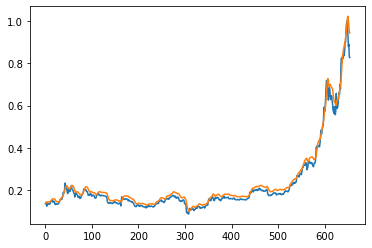

In [11]:
#Get predicted value
#multi_prediction_unscaled = multivariative_scaler_before.inverse_transform(multi_prediction)

plt.plot(y_test)
plt.plot(multi_prediction)